状態が常に同じで報酬が変化しない場合（状態が1つしかない）場合は，Qテーブルを使わなくてもいける

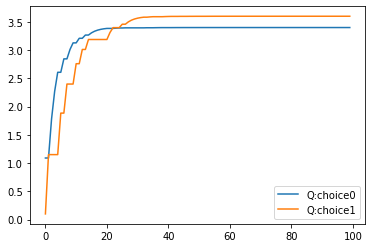

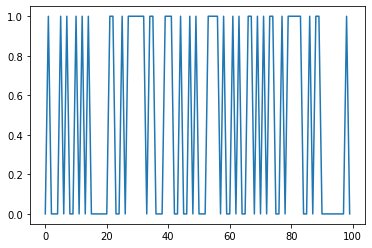

In [107]:
import numpy as np
import random
import math

num_of_trial = 100
num_of_choice = 2

# 現在のQ値を保持する．状態は常に同じ選択肢は常に同じものが2
Q = np.zeros((num_of_choice), dtype=np.float)

# 最尤推定のために選択肢を記録する
choice_array = np.zeros((num_of_trial), dtype=np.int)

# グラフの描画のために過去のQ値の変遷を100試行分格納する配列
Qpast = np.zeros((num_of_trial, num_of_choice), dtype=np.float)

#Qの初期値．両方とも同じに設定する
Q[0] = 0.1
Q[1] = 0.1

Qpast[0][0] = Q[0]
Qpast[0][1] = Q[1]

# その時点での選択確率を記録する配列
p_choice_array = np.zeros((num_of_trial, num_of_choice), dtype=np.float)

# 報酬は，選択肢0の時は常に1.0, 選択肢1の時は常に1.2
rewards = np.array([1.0, 1.2], dtype=np.float)

# 学習率アルファ
learning_rate = 0.3

# 減衰割引率ガンマ
decay_discount_factor = 2.0

# 選択方法
choice_algorithm = 'Softmax'

# Softmaxの逆温度
inverse_temperature = 1.0

for t in range(0, num_of_trial, 1):
  # 現在の試行回数がtに入る
  if choice_algorithm == 'Roulette':
    # ルーレット方式で選択肢を決定する　（一般的にはε-グリーディ法を使うので，ちょっと違うが，わかりやすくするため）
    # 現在のQ値のルーレットを作成
    sumQ = np.sum(Q)
    roulette_number = random.random() * sumQ
    if roulette_number < Q[0]:
      current_choice = 0
    else:
      current_choice = 1
  else:
    # Softmaxで行動を選択する
    p_choice_sm = np.zeros((num_of_choice), dtype=np.float)
    deno = 0.0
    for i in range(num_of_choice):
      # Softmaxの分母部分の計算
      deno += math.exp(inverse_temperature * Q[i])
    for i in range(num_of_choice): # 現在の状態において2つの選択を取る確率をそれぞれ計算
      p_choice_array[t][i] = p_choice_sm[i] = math.exp(inverse_temperature * Q[i]) / deno


    # 乱数を振ってどの選択か決める
    softmax_num = random.random()
    current_choice = num_of_choice - 1
    sum_p = 0.0
    for i in range(num_of_choice-1):
      sum_p += p_choice_sm[i]
      if softmax_num < sum_p:
        current_choice = i
        break

    if current_choice == 0:
      # 選択肢0が選ばれた
      current_rewards = rewards[0]
      # この計算では状態によって報酬は変わらないとしているので，次の状態の報酬の最大値は常に選択肢1の報酬になる
      nextQ0 = Q[0] + learning_rate * (current_rewards + decay_discount_factor * rewards[1] - Q[0])
      # 選択肢0のQ値を更新
      Qpast[t][0] = Q[0] = nextQ0
      # 選択肢1のQ値は変わらない
      Qpast[t][1] = Q[1]

    else:
      # 選択肢1が選ばれた
      current_rewards = rewards[1]
      # この計算では状態によって報酬は変わらないとしているので，次の状態の報酬の最大値は常に選択肢1の報酬になる
      nextQ1 = Q[1] + learning_rate * (current_rewards + decay_discount_factor * rewards[1] - Q[1])
      # 選択肢1のQ値を更新
      Qpast[t][1] = Q[1] = nextQ1
      # 選択肢0のQ値は変わらない
      Qpast[t][0] = Q[0]

  choice_array[t] = current_choice

import matplotlib.pyplot as plt
x_array = np.array([range(0, num_of_trial, 1)]).ravel()
# 描画のために選択肢0と1の系列を引っ張り出すため，transposeで次元をひっくり返す
Qpast = Qpast.transpose()
plt.plot(x_array, Qpast[0].ravel(), label='Q:choice0')
plt.plot(x_array, Qpast[1].ravel(), label='Q:choice1')

plt.legend()
plt.show()
# あっという間に収束する


plt.plot(x_array, choice_array, label='Choice')
plt.show()

こいつの学習率と割引率のパラメータを、最尤推定で推定してみる

Q学習の対数尤度は，
$\sum_{t=1}^{T} log P(a_{t}) $
で表される．

この時，$P(a_{t})$は，各試行の実際の選択$a_t$の選択確率であり，Softmax関数を使う場合はSoftmax関数そのままの値となる．
Softmax関数は，確率を出してくれるので合計1である．素晴らしい！

Rouletteの場合は，合計1にするように計算したrouletteの数値を記録しておく．

E-Greedyは0~1で発生させた乱数が$\epsilon$以下の時，選択肢がランダムに選ばれるので，
Q値が小さい方の選択肢が$\epsilon \times 0.5$,
Q値が大きい方の選択肢が$1-\epsilon\times 0.5$ となる（はず)

負の対数尤度を最小化するのが最尤推定なので，対数尤度の合計*-1でそのままいけるはず


負の対数尤度 71.97359902281211


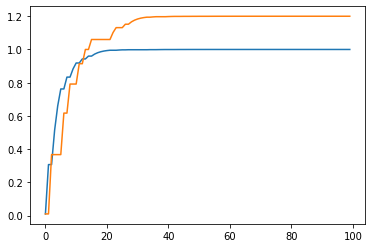

In [116]:
# まず普通にαとβを変数化したモデルで，Softmax関数を選択に使い，対数尤度を求めてみる
# Softmax関数を行動選択に使った時の対数尤度関数は，Softmax関数そのままなので，記録したQの選択行動

# まず関数化
def func_qlearning(param, choice, rewards):

  log_sum = 0.0 # 対数尤度を格納する
  alpha = param[0] #求めるパラメータ
  beta = param[1]

  # choiceは選択肢0か選択肢1かのどちらかが格納されている

  # Q値の初期化
  Q = np.zeros((len(choice), 2), dtype=np.float)
  # 一番最初だけ入れておく
  Q[0][0] = Q[0][1] = 0.01

  # 選択確率を格納する配列
  # ここでは選択肢は2つなので，選択肢０の場合の確率のみを記録すれば，もう片方は算出できることになる
  p_choice = np.zeros((len(choice)), dtype=np.float)

  # 試行回数ぶん回す
  for t in range(len(choice)):
    #deno = 0.0
    #for i in range(num_of_choice):
    #  # Softmaxの分母部分の計算
    #  deno += math.exp(inverse_temperature * Q[i])
    #for i in range(num_of_choice): # 現在の状態において2つの選択を取る確率をそれぞれ計算
    #  p_choice_array[t][i] = p_choice_sm[i] = math.exp(inverse_temperature * Q[i]) / deno

    # Softmax関数は，あらかじめ計算しておくと，以下の１行でまとまるらしい
    # （分子と分母を同じ数で割っておくのか）
    p_choice[t] = 1.0 / (1.0 + math.exp( -1 * beta *(Q[t][0] - Q[t][1])))

    # 試行tの対数尤度は
    # 実際の選択が，選択肢0であれば log(p_choice[t]), 
    # 選択肢１であればlog(1 - p_choice[t]) となる
    # この対数尤度を合計していく
    log_sum += math.log(p_choice[t]) if choice[t] == 0 else math.log(1 - p_choice[t])

    # ラスト試行でなければQ値を更新
    if t != (len(choice)-1):
      Q[t+1][choice[t]] = Q[t][choice[t]] + alpha * (rewards[choice[t]] - Q[t][choice[t]])
      # 選択されたかった方のQ値はそのまま継続
      Q[t+1][1-choice[t]] = Q[t][1-choice[t]]
    negative_log_sum = -1 * log_sum
  return negative_log_sum, Q, p_choice

# plotして同じになるか確認する
negative_log_sum, Q, p_choice = func_qlearning((0.3, 2.0), choice_array, (1.0, 1.2))
print('負の対数尤度', negative_log_sum)
Q0array = Q.transpose()[0]
Q1array = Q.transpose()[1]
plt.plot(x_array, Q0array, label='Q:Choice0')
plt.plot(x_array, Q1array, label='Q:Choice1')
plt.show()


負の対数尤度: 69.34974138725978 Alpha: 0.17676767676767677 Beta: 0.1


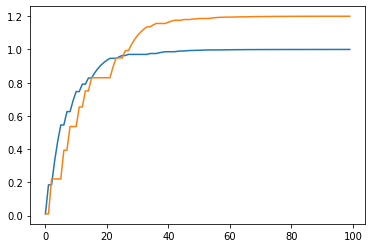

In [117]:
# とりあえずグリッドサーチで，αとβを求めてみる
mesh_alpha = np.linspace(0.1, 2.0, 100)
mesh_beta = np.linspace(0.1, 2.0, 100)
mesh_result_negative_log_likelifood = np.zeros((100, 100), dtype=np.float)

alpha_index = 0
for alpha in mesh_alpha:
  beta_index = 0
  for beta in mesh_beta:
    mesh_result_negative_log_likelifood[alpha_index][beta_index], Q, p_choice = func_qlearning((alpha, beta), choice_array, (1.0, 1.2))
    beta_index += 1
  alpha_index += 1

# 一番負の対数尤度が低いのは
result_indexes = np.unravel_index(np.argmin(mesh_result_negative_log_likelifood), mesh_result_log_likelifood.shape)

# 同じになるか確認する
result_negative_log_sum, Q, p_choice = func_qlearning((mesh_alpha[result_indexes[0]], mesh_beta[result_indexes[1]]), choice_array, (1.0, 1.2))
print('負の対数尤度:', result_negative_log_sum, 'Alpha:', mesh_alpha[result_indexes[0]], 'Beta:', mesh_beta[result_indexes[1]])
plt.plot(x_array, Q.transpose()[0], label='Q:Choice0')
plt.plot(x_array, Q.transpose()[1], label='Q:Choice1')
plt.show()

In [128]:
# scipyのoptimizeを使った数値最適化
# 最尤推定
# https://github.com/kkatahira/cmbd-book/blob/master/chapter2/qlearning_simulation.R
# http://palloc.hateblo.jp/entry/2016/01/17/231245
# https://qiita.com/fukuit/items/c7ae3f71898399530dc1
# を参照

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
from scipy.optimize import fmin

# 最小値だけを取り出すラッパ関数を作っておく
def func_minimize(param, choice, rewards):
  negative_log_sum, Q, p_choice = func_qlearning(param, choice, rewards)
  return negative_log_sum

arg=(choice_array, rewards)


print(fmin(func_minimize, (1.0, 1.0), args=arg))

# 初期値を一様乱数で適当に定めて10回分回す
min_negative_log_sum = 1000000
result_alpha = None
result_beta = None
for i in range(10):
  # どうも最適化途中で，logでmath domain errorが起きるらしい．つまりlogに0が入る状況になる
  # どうやって解決したものか
  initial_alpha = np.random.random() * 1.0 + 1.0
  initial_beta = np.random.random() * 1.0 + 1.0
  result_array = fmin(func_minimize, (initial_alpha, initial_beta), args=arg, retall=True, full_output=True)
  if result_array[1] < min_negative_log_sum:
    # Full Outputのとき，結果配列の0番目が最適化されたパラメータ，1番目が最小化された戻り値である
    min_negative_log_sum = result_array[1]
    reulst_alpha = result_array[0][0]
    result_beta = result_array[0][1]
print('Alpha:', result_alpha, 'Beta:', result_beta, 'Negative_LL:', min_negative_log_sum)

Optimization terminated successfully.
         Current function value: 68.349791
         Iterations: 41
         Function evaluations: 79
[ 1.46165346 -1.02779416]


ValueError: ignored

状態が複数あり，かつ報酬が状態によって変わるので，Q-tableを使う場合

[[1.13394025 1.36613644 1.02506122]
 [1.41145615 1.43326173 1.22024845]
 [1.09589599 1.20368855 1.41071561]
 [1.10477714 1.14051966 1.37240686]]
[[2.27359767 2.45546375 0.1       ]
 [2.55650707 2.56541474 1.87052608]
 [0.1        1.90023835 2.55456834]
 [1.7821621  0.1        2.50929399]]


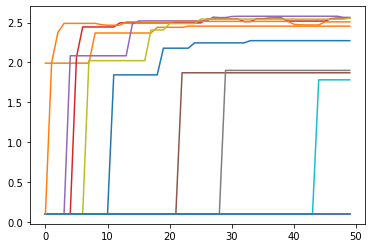

In [0]:
import numpy as np
import random

num_of_state = 4 #状態数
num_of_choice = 3 #選択肢数
num_of_trials = 50 # 試行回数

# 現在のQ値を保持するQ-table．状態数4，選択肢数3(0~3), 初期値を0.1で入れておく
# 最初の選択をするために，最初のQ値が必要となるから
Q = np.full((num_of_state, num_of_choice), 0.1, dtype=np.float)

# グラフの描画のために過去のQ値の変遷を100試行分格納する配列
# 状態数*選択肢数分保持する
Qpast = np.zeros((num_of_trials, num_of_state, num_of_choice), dtype=np.float)

# この計算では，報酬は，状態数*選択肢数の配列で，固定しておく
# つまり，選択した行動の報酬は現在の状態によって変わるが，探索中に動いたりはしない
# 1~1.5のランダムな値を入れておく
rewards = np.zeros((num_of_state, num_of_choice), dtype=np.float)
for i in range(num_of_state):
  for j in range(num_of_choice):
    rewards[i][j] = random.random() * 0.5 + 1.0
print(rewards)

# 学習率アルファ
learning_rate = 0.8

# 減衰割引率ガンマ
decay_discount_factor = 0.8

# 初期状態は，状態0とする
current_status = 0
# 100試行分の状態を記録する配列を作っておく
status_past = np.zeros((num_of_trials), dtype=np.int)
status_past[0] = current_status

# 選択アルゴリズム
# E-Greeddy, Roulette or Softmax
# ε-グリーディの，通常選択のアルゴリズム， Roulette or Softmax
choice_algorithm = 'Softmax'
# Softmaxの逆温度 1.0以上の値が入る．逆温度が大きいとSoftmaxがスレッショルドに近くなる
inverse_temperature = 1.0

# 状態遷移テーブルを作る
# この状態の時，この選択肢が選択されたら，次の状態が決まるというやつ
# これは確率にしても良いし，現在の状態とか状態の蓄積から決定木を書いても良い
# とりあえず確率にしておく
# 確率なので，1つの状態から1つの選択肢で移動する状態の確率は1.0である必要がある．
# 状態は再帰の場合もあることとする
status_transition_ratio = np.zeros((num_of_state, num_of_choice, num_of_state), dtype=np.float)

# 一つの状態で一つの選択肢からの状態遷移の総和が1.0になるように，ランダムに値を入れる
for i in range(num_of_state):
  for j in range(num_of_choice):
    s_array = np.zeros((num_of_state), dtype=np.float)
    for k in range(num_of_state):
      s_array[k] = random.random()
    for k in range(num_of_state):
      status_transition_ratio[i][j][k] = 1.0 / np.sum(s_array) * s_array[k]

# 状態遷移確率テーブルの出力
#for i in range(num_of_state):
#  print(status_transition_ratio[i])

# 終端状態が存在する場合は，初期状態に戻ることを確率として書いておけば良い

for t in range(0, num_of_trials, 1):
  # 現在の試行回数がtに入る
  
  if choice_algorithm == 'E-Greedy':
    # ε-グリーディ法で行動を選択する

    # ある適当な定数を用意（ε = 0.3）
    # 行動選択の際、0~1の間の乱数を生成し、その値がε以下であればランダムに行動を選択する
    # εより大きければQ値の大きい行動を選択する(ルーレット選択かSoftmax)ようにする
    epsilon = 0.3
    if random.random() < epsilon:
      current_choice = random.randint(0, num_of_choice-1)
      # randint(a, b)は a <= x <= bであることに注意
    else:
      # 0~1乱数がEpsilonより大きい時は，現在の一番Q値が大きい選択肢を選ぶ
      current_choice = np.argmax(Q[current_status])

  elif choice_algorithm == 'Roulette':
    # ルーレットで行動を選択する
    # 現在の状態におけるQ値の各選択肢のルーレットを作成
    sumQ = np.sum(Q[current_status])
    roulette_number = random.random() * sumQ

    # 選択肢の決定
    current_choice = num_of_choice -1
    sum_p = 0.0
    for i in range(num_of_choice -1):
      sum_p += Q[current_status][i]
      if roulette_number < sum_p:
        current_choice = i
        break
  else:
    # Softmaxで行動を選択する
    p_choice_sm = np.zeros((num_of_choice), dtype=np.float)
    deno = 0.0
    for i in range(num_of_choice):
      # Softmaxの分母部分の計算
      deno += math.exp(inverse_temperature * Q[current_status][i])
    for i in range(num_of_choice): # 現在の状態において3つの選択を取る確率をそれぞれ計算
      p_choice_sm[i] = math.exp(inverse_temperature * Q[current_status][i]) / deno
    # 乱数を振ってどの選択か決める
    softmax_num = random.random()
    current_choice = num_of_choice - 1
    sum_p = 0.0
    for i in range(num_of_choice-1):
      sum_p += p_choice_sm[i]
      if softmax_num < sum_p:
        current_choice = i
        break

  # 選択肢による報酬の決定
  current_rewards = rewards[current_status][current_choice]
  # 次の状態を状態遷移確率テーブルから選ぶ

  transition_ratio_in_current_status = status_transition_ratio[current_status][current_choice]
  sum_transition_ratio = np.sum(transition_ratio_in_current_status)
  roulette_number = random.random() * sum_transition_ratio
  sum_p = 0.0
  next_status = num_of_state - 1
  for i in range(num_of_state-1):
    sum_p += transition_ratio_in_current_status[i]
    if roulette_number < sum_p:
      next_status = i
      break

  # 次の状態での報酬の最大値を決定する
  max_next_step_rewards = np.max(rewards[next_status])
  nextQ = Q[current_status][current_choice] + learning_rate * (current_rewards + decay_discount_factor * max_next_step_rewards - Q[current_status][current_choice])

  # Q-tableを更新
  Q[current_status][current_choice] = nextQ

  # Q値の変遷を記録
  for i in range(num_of_state):
    for j in range(num_of_choice):
      Qpast[t][i][j] = Q[i][j]
  
  # 現在の状態を置き換え
  current_status = next_status

#最終的なQ-tablewを出力
print(Q)

import matplotlib.pyplot as plt
x_array = np.array([range(0, num_of_trials, 1)]).ravel()

for i in range(num_of_state):
  for j in range(num_of_choice):
    # y軸の配列，つまり，その状態とその選択肢のQ値の変遷を取り出す
    Qpast_in_one_array = np.zeros((num_of_trials), dtype=np.float)
    for t in range(num_of_trials):
      Qpast_in_one_array[t] = Qpast[t][i][j]
    # 表示用ラベルを作る
    display_label = 'Q:' + 'status' + str(i) + ',choice' + str(j)
    plt.plot(x_array, Qpast_in_one_array, label=display_label)

# plt.legend()
plt.show()